# Neural Networks (NN) Implementation

#### In this jupyter notebook, I implement a neural network and use it to classify patients into 5 categories, corresponding to a treatment that works on them based on their health vitals. The dataset for this is in https://www.kaggle.com/datasets/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees, but it does not appear to be from a real-world case; rather, it is simulated. 

#### The data has 5 features of each patient that can help determine which of the five drugs will treat them best. Some of these features are numerical (age, sodium-potassium ratio) and some need to be encoded into numbers, as they are categories (sex, blood pressure, cholesterol). 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Import & Filter the Data

In [2]:
df = pd.read_csv("drug200.csv")

#separate features from target
X_raw = df[["Age", "Sex", "BP", "Cholesterol", "Na_to_K"]]
y_raw = df["Drug"]

# Encode categorical features (Sex, BP, Cholesterol) 
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(X_raw[["Sex", "BP", "Cholesterol"]])

# Numerical features (Age, Na_to_K) are standardized
X_num = StandardScaler().fit_transform(X_raw[["Age", "Na_to_K"]])

#All features are combined into a single input matrix X.
X = np.hstack([X_num, X_cat])

# The target variable (Drug) is mapped to integers and one-hot encoded to be compatible with softmax output

# Encode labels
labels = sorted(y_raw.unique())
label_map = {label: i for i, label in enumerate(labels)}
y_int = y_raw.map(label_map).values

# One-hot encode target
y = np.eye(len(labels))[y_int]

## NN Algorithm

### Defining functions first - needed for activation and calculating loss

In [3]:
# Defining the softmax function for multi-class output
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Defining the ReLU function for the hidden layer activation
def relu(z):
    return np.maximum(0, z)

# Defining the ReLU function derivative for backpropagation. 
def relu_derivative(z):
    return (z > 0).astype(float)

# Defining categorical cross-entropy, the loss function used to compare predicted probabilities to the true one-hot encoded labels.

def categorical_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

### Initializing the model

In [4]:
# Train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize weights and biases for both layers using small random values (for weights) and zeros (for biases). 
# W1 and b1 belong to the hidden layer, while W2 and b2 belong to the output layer.

input_size = X.shape[1]
hidden_size = 10
output_size = len(labels)

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

### Training the NN

In [5]:
# Training with SGD: stochastic gradient descent

epochs = 30000
lr = 0.01 # learning rate

# Each iteration includes a forward pass, loss calculation, backpropagation, and weight updates

losses = []
for epoch in range(epochs):
    # Forward pass - computes activation for the hidden and output neuron layers
    Z1 = X_train.dot(W1) + b1  #linear input to the hidden layer
    A1 = relu(Z1)              #activated hidden layer output
    Z2 = A1.dot(W2) + b2       #linear input to the output layer
    A2 = softmax(Z2)           #final softmax output
    
    # Compute loss
    loss = categorical_cross_entropy(y_train, A2)
    losses.append(loss)

    # Backpropagation - calculate gradients for the weights
    dZ2 = A2 - y_train                                          #gradient of the loss with respect to Z2
    dW2 = A1.T.dot(dZ2) / X_train.shape[0]                      #multiply hidden activations by dZ2 (output error) to find out how each hidden neuron contributed to the output error
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0] #sum of all samples to find out how much output neuron bias should change

    dA1 = dZ2.dot(W2.T)                                         #the error at the output affects activations in hidden layer
    dZ1 = dA1 * relu_derivative(Z1)                             
    dW1 = X_train.T.dot(dZ1) / X_train.shape[0]                 #how much each hidden node weight should be updated
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0] #how much each hidden node bias should be updated

    # Parameter update - based on the learning rate and gradients
    W1 -= lr * dW1 
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    
    if epoch == 3000: #saving values for future plotting
        W1_epoch_500 = W1.copy()
        b1_epoch_500 = b1.copy()
        W2_epoch_500 = W2.copy()
        b2_epoch_500 = b2.copy()


    if epoch % 3000 == 0:
        print(f"Epoch {epoch} - Loss: {loss:.4f}")

Epoch 0 - Loss: 1.6094
Epoch 3000 - Loss: 0.5340
Epoch 6000 - Loss: 0.1827
Epoch 9000 - Loss: 0.0785
Epoch 12000 - Loss: 0.0482
Epoch 15000 - Loss: 0.0350
Epoch 18000 - Loss: 0.0275
Epoch 21000 - Loss: 0.0225
Epoch 24000 - Loss: 0.0191
Epoch 27000 - Loss: 0.0165


## Result

In [6]:
# evaluate the NN using the weights and biases found above
def predict(X):
    A1 = relu(X.dot(W1) + b1)
    A2 = softmax(A1.dot(W2) + b2)
    return np.argmax(A2, axis=1)

y_pred = predict(X_test)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true) #tests the accuracy of the predictions
print(f"\nTest accuracy: {accuracy:.4f}")


Test accuracy: 0.9750


## Analysis & Discussion

Clearly, the neural network produces accurate results after a lot (30,000) epochs. But does it get there quickly? Slowly? Does it get stuck at some point? 

To see how close the neural network gets to perfection as epochs progress, I plot the progression of the loss function for the first 10,000 epochs (left) and its progression for the full 30,000 epochs (right).

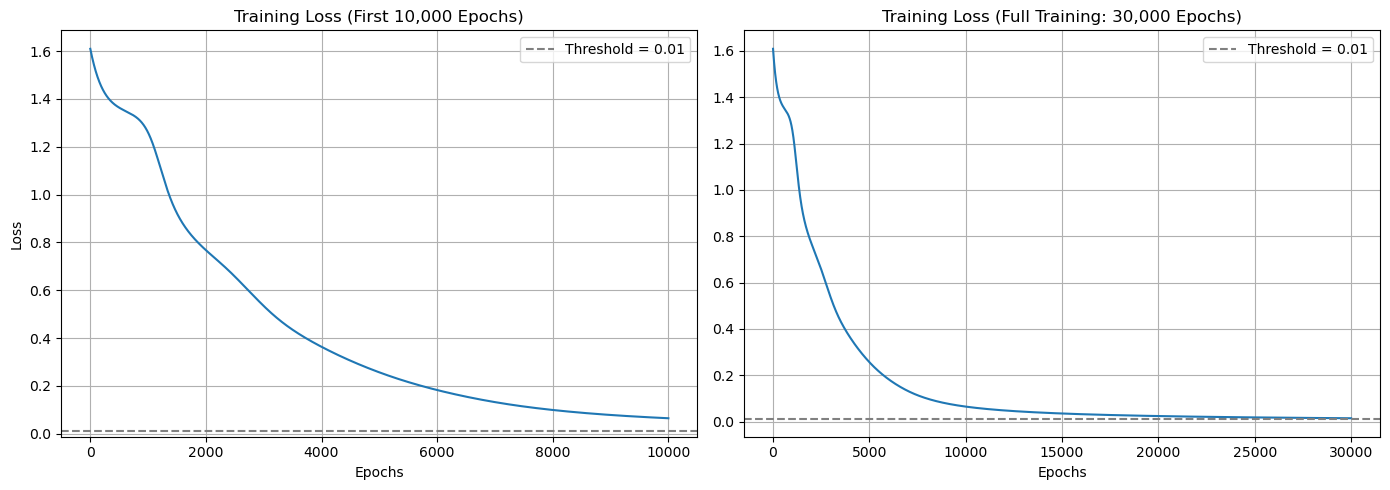

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# --- Plot 1: Zoom in to first 10,000 epochs ---
axs[0].plot(range(10000), losses[:10000])
axs[0].set_title("Training Loss (First 10,000 Epochs)")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].axhline(y=0.01, color='gray', linestyle='--', label='Threshold = 0.01')
axs[0].legend()
axs[0].grid(True)

# --- Plot 2: Full training loss (e.g., 30,000 epochs) ---
axs[1].plot(range(len(losses)), losses)
axs[1].set_title("Training Loss (Full Training: 30,000 Epochs)")
axs[1].set_xlabel("Epochs")
axs[1].axhline(y=0.01, color='gray', linestyle='--', label='Threshold = 0.01')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

These plots show that the neural network learns effectively, getting much better with less time at the start, before eventually slowing down to almost a plateau near the Loss = 0 axis. 

There is clearly a very fast learning step for the first few hundred epochs, then the NN looks to hit a plateau near Epochs = 500, though it overcomes it around Epochs = 1000.

Another positive sign is that there are no spikes.

In [8]:
def evaluate_and_plot_cm(W1, b1, W2, b2, X_test, y_test, labels, title):
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def relu(z):
        return np.maximum(0, z)

    A1 = relu(X_test.dot(W1) + b1)
    A2 = softmax(A1.dot(W2) + b2)
    y_pred = np.argmax(A2, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

To get more into the details of how the categorization went, I make an expanded confusion matrix, which shows where each true label ended up being predicted. As can be seen below, the predictions are almost completely correct for this large epoch (one drug Y entry was predicted to be drug A). But if we pull the results of an intermediary point and make predictions based on the weights and biases at epoch 3,000, we can see an earlier confusion matrix, where there are many non-zero values off of the diagonal.

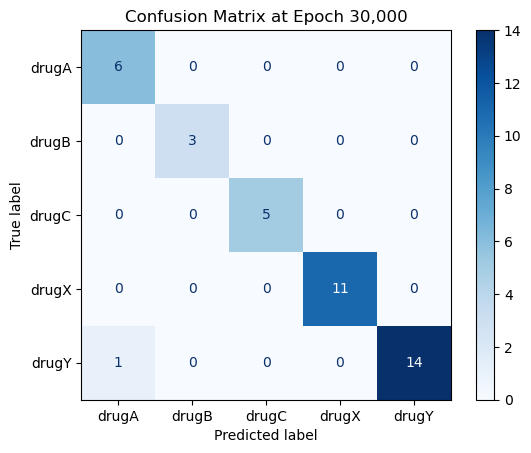

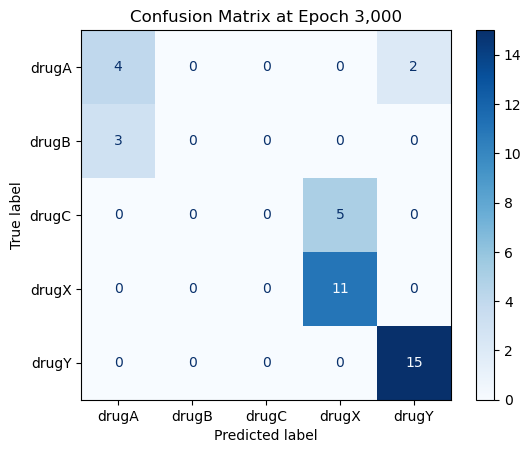

In [11]:
# Labels like: ['drugA', 'drugB', ...]
evaluate_and_plot_cm(W1, b1, W2, b2, X_test, y_test, labels, "Confusion Matrix at Epoch 30,000")

evaluate_and_plot_cm(W1_epoch_500, b1_epoch_500, W2_epoch_500, b2_epoch_500, X_test, y_test, labels, "Confusion Matrix at Epoch 3,000")


One last analysis we can run on the results is to use Principal Component Analysis (PCA) to project the 10-dimensional hidden layer activations into 2D for visualization. Each point represents a test example, colored in 5 different colors encoded on the sidebar as integers from 0 to 4. This lets us assess how well the neural network internally separates the classes. Clear clusters indicate that the network has learned class-specific internal representations.

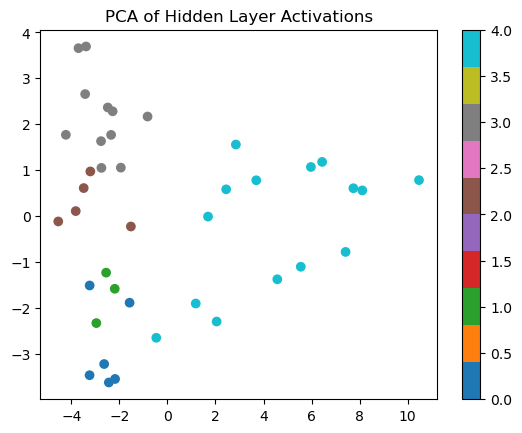

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
A1_proj = pca.fit_transform(A1_test)

plt.scatter(A1_proj[:, 0], A1_proj[:, 1], c=y_true, cmap='tab10')
plt.title("PCA of Hidden Layer Activations")
plt.colorbar()
plt.show()


The PCA projection of hidden layer activations shows that the neural network has learned internal representations that cluster examples by drug class. Some classes (e.g., Drug Y and Drug A) form well-separated groups, indicating strong confidence and good feature learning. Others (e.g., Drug B and Drug X) are more mixed, suggesting overlap in input patterns or less informative features for those categories.

